In [1]:
#Importação das Bibliotecas
import os 
import sys 
import findspark
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

In [2]:
findspark.init(r'C:\Users\fabio\Documents\Infnet\Engenharia_de_Dados\InfraestruturaCassandra\TrabalhoFinal\csv\spark')
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import *
from pyspark.sql import *

In [3]:
# Configuração de parâmetros SparkConf()
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.datastax.spark:spark-cassandra-connector_2.12:3.2.0 pyspark-shell'
conf = SparkConf()
conf.set("spark.cassandra.auth.username", "cassandra")
conf.set("spark.cassandra.auth.password", "cassandra")
conf.set("spark.cassandra.connection.host", "172.17.0.2")
conf.set("spark.cassandra.connection.local_dc", "dc1")

In [4]:
# Criação do contexto
sc = SparkContext().getOrCreate(conf)
sqlContext = SQLContext(sc)

C:\Users\fabio\Documents\Infnet\Engenharia_de_Dados\InfraestruturaCassandra\TrabalhoFinal\csv\spark\python\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [5]:
# Carregando tabela car sales da keyspace trabalho_final da Infraestrutura Cassandra
cars = sqlContext.read.format("org.apache.spark.sql.cassandra").load(table="car_sales", keyspace="trabalho_final")

In [6]:
# Mostrando as cinco primeiras linhas
cars.show(5)

+----------+------+
|      date| value|
+----------+------+
|01,12,2006|204801|
|01,04,2006|131139|
|01,10,1996|163423|
|01,01,1994| 93915|
|01,06,1990| 37632|
+----------+------+
only showing top 5 rows



In [7]:
# Passando para o pandas
df = cars.toPandas()

In [8]:
# Verificando tipos das colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    392 non-null    object
 1   value   392 non-null    object
dtypes: object(2)
memory usage: 6.2+ KB


In [9]:
df.tail(5)

,date,value
387,"01,06,2021",182408
388,"01,07,2009",285370
389,"01,08,1994",159083
390,"01,10,2020",215024
391,"01,11,2006",182709


In [10]:
# Renomeando coluna 'values' para 'vendas_carros' e 'date' para 'data'
df.rename(columns={'value' : 'vendas_carros', 'date' : 'data'}, inplace=True)

In [11]:
# Passando campo 'date' para tipo datetime
df['data'] = pd.to_datetime(df['data'], format="%d,%m,%Y")

In [12]:
df['vendas_carros'] = df['vendas_carros'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   data           392 non-null    datetime64[ns]
 1   vendas_carros  392 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.2 KB


In [13]:
# Qual o número de vendas de carros no mês de maio do ano de 1996 ?
df.loc[df['data'] == '1996-05-01']

,data,vendas_carros
69,1996-05-01,147166


In [14]:
# Qual o número de vendas no primeiro trimestre do ano 2005 para cada mês ?
primeiro_trimestre_2000 =  df[(df['data'] >= '2005-01-01') & (df['data'] <= '2005-03-01')]
primeiro_trimestre_2000

,data,vendas_carros
236,2005-01-01,106660
289,2005-03-01,149478
307,2005-02-01,114816


In [15]:
# Qual o número de vendas de carros para o ano de 2020 ?
ano_2020 = df[(df['data'] >= '2020-01-01') & (df['data'] <= '2020-12-01')]
ano_2020['vendas_carros'].sum()

2058146

In [16]:
# Qual o número de vendas de carros para o ano de 2021 ?
ano_2021 = df[(df['data'] >= '2021-01-01') & (df['data'] <= '2021-12-01')]
ano_2021['vendas_carros'].sum()

2119538

In [17]:
# Qual o número de vendas de carros para o ano de 2022 ?
ano_2022 = df[(df['data'] >= '2022-01-01') & (df['data'] <= '2022-12-01')]
ano_2022['vendas_carros'].sum()

1308416

In [18]:
# Quais os cinco meses com maior número de vendas para o ano de 2021 ?
ano_2021.sort_values(by='vendas_carros', ascending=False).head(5)

,data,vendas_carros
245,2021-12-01,207062
311,2021-03-01,189372
272,2021-05-01,188612
387,2021-06-01,182408
118,2021-07-01,175426


In [19]:
# Quais os três piores meses de vendas para o ano de 2021 ?
ano_2021.nsmallest(3, 'vendas_carros')[['data','vendas_carros']]

,data,vendas_carros
230,2021-09-01,155067
95,2021-10-01,162353
194,2021-02-01,167341


In [20]:
# Extraindo ano de date
df['ano'] = df['data'].dt.year
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   data           392 non-null    datetime64[ns]
 1   vendas_carros  392 non-null    int64         
 2   ano            392 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 9.3 KB


In [21]:
# Total de vendas de carros por ano
anos = df.groupby('ano')['vendas_carros'].sum()
anos

ano
1990     712708
1991     791508
1992     771477
1993    1098191
1994    1426651
1995    1684846
1996    1728558
1997    1931016
1998    1546618
1999    1176881
2000    1411752
2001    1586928
2002    1466487
2003    1431381
2004    1578836
2005    1714724
2006    1925898
2007    2462605
2008    2820963
2009    3141009
2010    3515039
2011    3632974
2012    3801703
2013    3767165
2014    3497818
2015    2568980
2016    2050362
2017    2239405
2018    2566009
2019    2787618
2020    2058146
2021    2119538
2022    1308416
Name: vendas_carros, dtype: int64

In [22]:
# Exportando para arquivo .csv o total de vendas de carros por ano
anos.to_csv('vendas_carros_ano.csv', sep=';')

Text(0, 0.5, 'Quantidade')

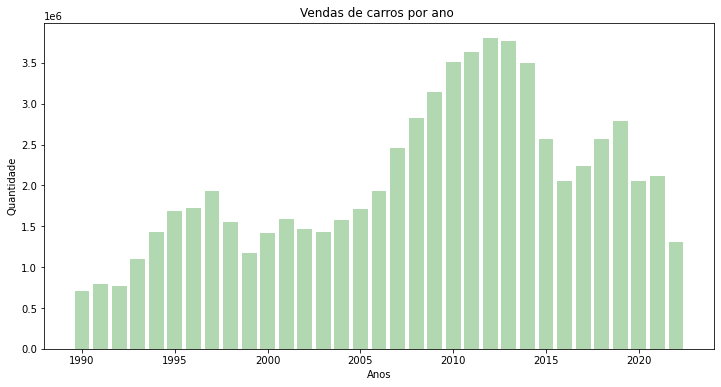

In [23]:
# Plotando gráfico de barras de vendas carros agrupadas por ano
plt.rcParams['figure.figsize']=(12,6)
plt.bar(anos.index, anos, color='green', alpha=0.3)
plt.title('Vendas de carros por ano ')
plt.xlabel('Anos')
plt.ylabel('Quantidade')

In [24]:
# Ordenando date por ordem cronológica de mês
ano_2020.sort_values(by='data', ascending=True, inplace=True)
ano_2021.sort_values(by='data', ascending=True, inplace=True)
ano_2022.sort_values(by='data', ascending=True, inplace=True)

C:\Users\fabio\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [25]:
# Trabalhando coluna de mês no ano 2020
ano_2020['mes'] = ano_2020['data'].dt.month
ano_2020.drop(columns=['data'], inplace=True)
ordem = ['mes', 'vendas_carros']
ano_2020 = ano_2020[ordem]

C:\Users\fabio\AppData\Local\Temp/ipykernel_42588/2024658481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ano_2020['mes'] = ano_2020['data'].dt.month
C:\Users\fabio\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [26]:
# Trabalhando coluna de mês no ano 2021
ano_2021['mes'] = ano_2021['data'].dt.month
ano_2021.drop(columns=['data'], inplace=True)
ordem = ['mes', 'vendas_carros']
ano_2021 = ano_2021[ordem]

C:\Users\fabio\AppData\Local\Temp/ipykernel_42588/174665184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ano_2021['mes'] = ano_2021['data'].dt.month


In [27]:
# Trabalhando coluna de mês no ano 2022
ano_2022['mes'] = ano_2022['data'].dt.month
ano_2022.drop(columns=['data'], inplace=True)
ordem = ['mes', 'vendas_carros']
ano_2022 = ano_2022[ordem]

C:\Users\fabio\AppData\Local\Temp/ipykernel_42588/1204311685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ano_2022['mes'] = ano_2022['data'].dt.month


In [28]:
# Gráfico comparativo entre ano 2020 e 2022

# Passando colunas de meses para formato lista
mes_2020 = ano_2020['vendas_carros'].tolist()
mes_2021 = ano_2021['vendas_carros'].tolist()
mes_2022 = ano_2022['vendas_carros'].tolist()
mes_2022.extend([0, 0, 0, 0])

# Largura das barras
barWidth = 0.25

# posição das barras
r1 = np.arange(len(ano_2020))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

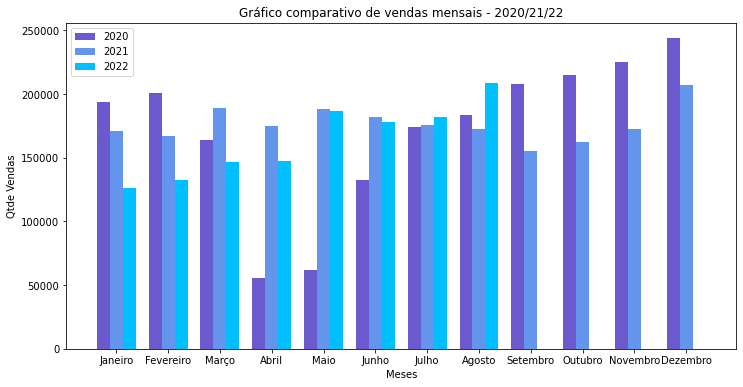

In [29]:
# Criando as barras
plt.bar(r1, mes_2020, color= '#6A5ACD', width=barWidth, label='2020')
plt.bar(r2, mes_2021, color= '#6495ED', width=barWidth, label='2021')
plt.bar(r3, mes_2022, color= '#00BFFF', width=barWidth, label='2022')

# Adicionando legendas
plt.xlabel('Meses')
plt.xticks([r + barWidth for r in range(len(ano_2021))], ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 
                                                         'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro'])
plt.ylabel('Qtde Vendas')
plt.title('Gráfico comparativo de vendas mensais - 2020/21/22')

# Plotando legenda e gráfico
plt.legend()
plt.show()

In [30]:
# Extraindo valores de vendas dos anos de 2020 à 2022.
anos_values = anos.tolist()
ano_2022 = anos_values.pop()
ano_2021 = anos_values.pop()
ano_2020 =anos_values.pop()

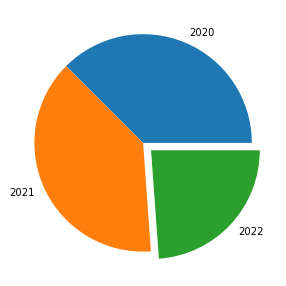

In [31]:
# Montando gráfico de pizza
plt.rcParams['figure.figsize']=(10,5)
data = [ano_2020, ano_2021, ano_2022]
rotulos = ['2020', '2021', '2022']
explosao = [0, 0, 0.1]

plt.pie(data, labels = rotulos, explode = explosao)
plt.show()

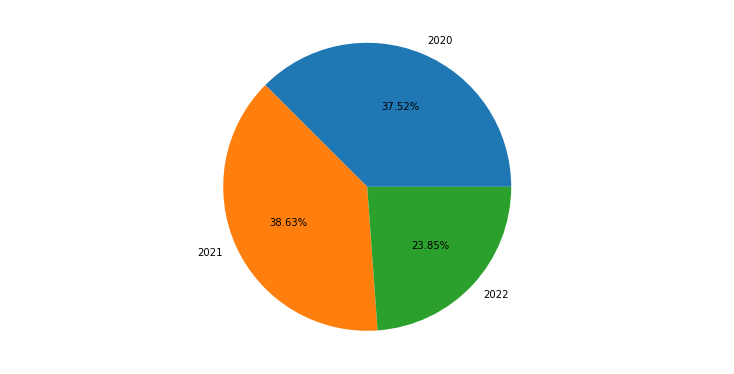

In [32]:
# Outro gráfico de pizza
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(data, labels = rotulos, autopct='%1.2f%%')
plt.show()